# First attempt at making nifty work for the MUSTANG data

## Step 1: Load input map

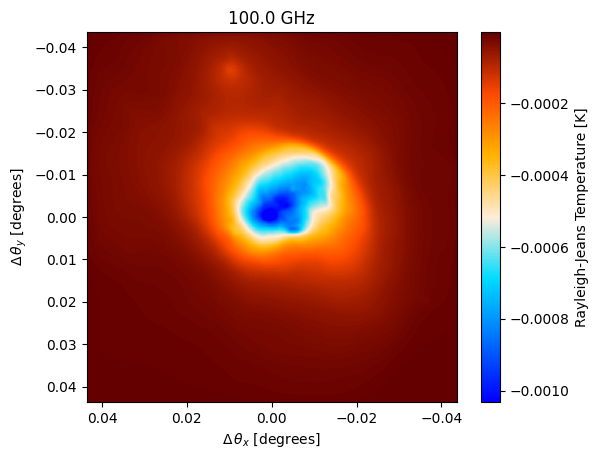

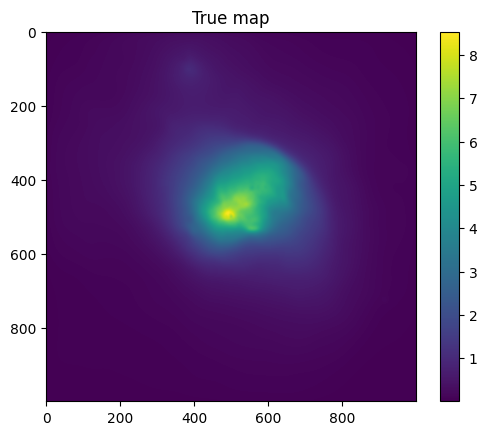

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import maria

import jax.numpy as jnp

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()
plt.show()

# Sava mapdata as jax array
mapdata_input = np.float64((input_map.data[0].T)*-1e7)

plt.imshow(mapdata_input)
plt.colorbar()
plt.title('True map')
plt.show()

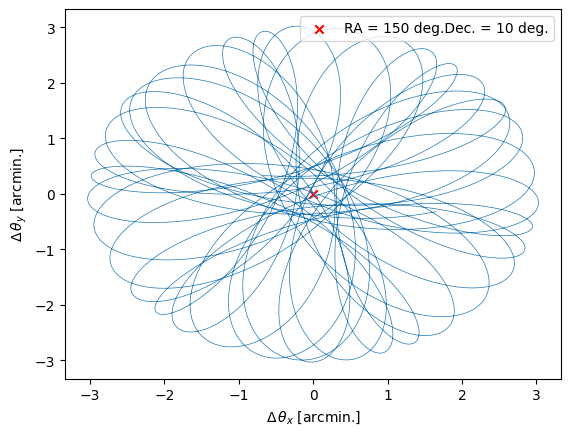

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

In [3]:
instrument = maria.get_instrument('MUSTANG-2')
# instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       noise=False,
                      #  atmosphere="2d",
                    #    cmb="generate",
                      )

tod_truthmap = sim_truthmap.run()

sim_noisedmap = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                      #  map=input_map,
                      #  noise=False,
                      #  atmosphere="2d",
                    #    cmb="generate",
                      )

tod_noisedmap = sim_noisedmap.run()

sim_cmb = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                      #  map=input_map,
                       noise=False,
                      #  atmosphere="2d",
                       cmb="generate",
                      #  cmb_kwargs={"nside": 8192}
                      )

tod_cmb = sim_cmb.run()

2024-07-18 13:18:54.208 INFO: Constructed instrument.
2024-07-18 13:18:54.208 INFO: Constructed plan.
2024-07-18 13:18:54.209 INFO: Constructed site.
2024-07-18 13:18:54.739 INFO: Constructed boresight.
2024-07-18 13:18:54.986 INFO: Constructed offsets.


Initialized base in 779 ms.


Sampling map (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]
2024-07-18 13:18:57.377 INFO: Constructed instrument.
2024-07-18 13:18:57.378 INFO: Constructed plan.
2024-07-18 13:18:57.378 INFO: Constructed site.
2024-07-18 13:18:57.497 INFO: Constructed boresight.


HERE shape (217, 30000)
HERE 2 shape (217, 30000)


2024-07-18 13:18:57.719 INFO: Constructed offsets.


Initialized base in 342 ms.


Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
2024-07-18 13:18:58.153 INFO: Constructed instrument.
2024-07-18 13:18:58.154 INFO: Constructed plan.
2024-07-18 13:18:58.154 INFO: Constructed site.
2024-07-18 13:18:58.271 INFO: Constructed boresight.
2024-07-18 13:18:58.492 INFO: Constructed offsets.


Initialized base in 339 ms.


Generating CMB:   0%|          | 0/1 [00:00<?, ?it/s]2024-07-18 13:18:58.945 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
2024-07-18 13:18:58.946 INFO: -> fwhm is 0.000000 arcmin
Sampling CMB (m2/f093): 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


## Re-make map with maria:

calling _run for band m2/f093


Running mapper (m2/f093):   0%|          | 0/1 [00:00<?, ?it/s]

self.tods: [TOD(shape=(217, 30000), fields=['map'])]
TOD(shape=(217, 30000), fields=['map'])
Band_tod: TOD(shape=(217, 30000), fields=['map'])


Running mapper (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


calling _run for band m2/f093


Running mapper (m2/f093):   0%|          | 0/1 [00:00<?, ?it/s]

self.tods: [TOD(shape=(217, 30000), fields=['noise'])]
TOD(shape=(217, 30000), fields=['noise'])
Band_tod: TOD(shape=(217, 30000), fields=['noise'])


Running mapper (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


calling _run for band m2/f093


Running mapper (m2/f093):   0%|          | 0/1 [00:00<?, ?it/s]

self.tods: [TOD(shape=(217, 30000), fields=['cmb'])]
TOD(shape=(217, 30000), fields=['cmb'])
Band_tod: TOD(shape=(217, 30000), fields=['cmb'])


Running mapper (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


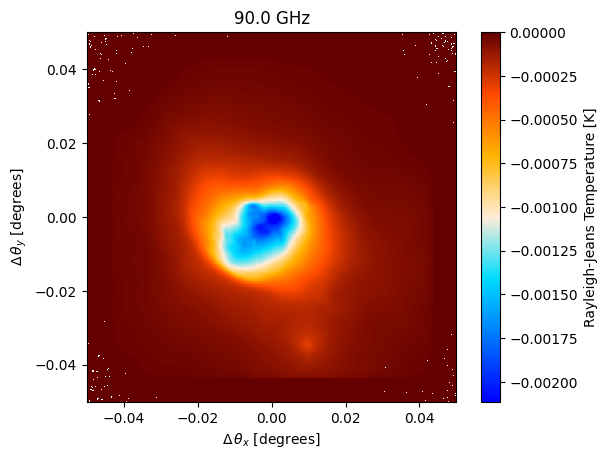

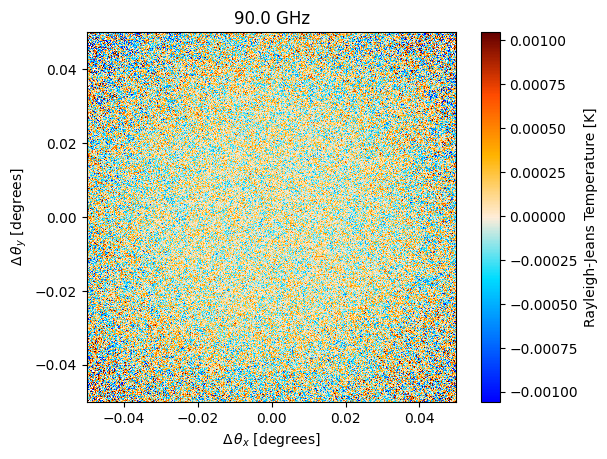

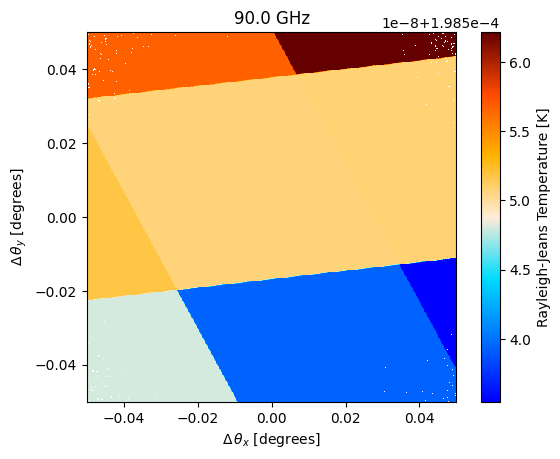

In [4]:
from maria.map.mappers import BinMapper

mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapper_noisedmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_noisedmap.add_tods(tod_noisedmap)
output_noisedmap = mapper_noisedmap.run()

mapper_cmb = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_cmb.add_tods(tod_cmb)
output_cmb = mapper_cmb.run()

output_truthmap.plot()
output_noisedmap.plot()
output_cmb.plot()

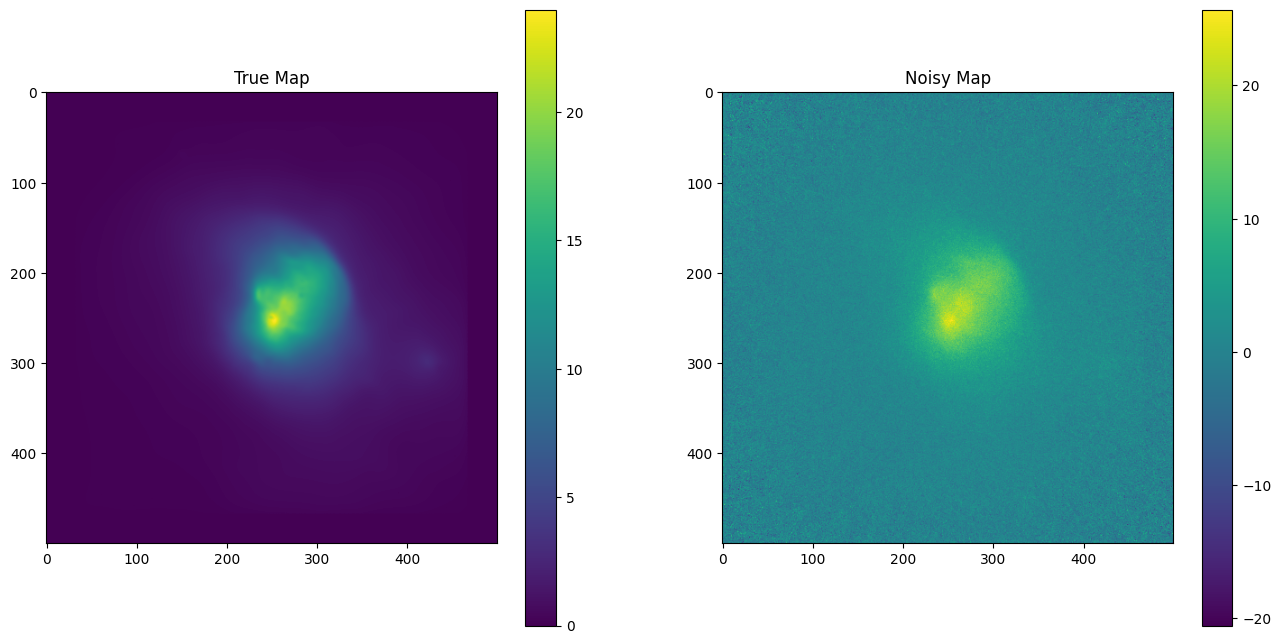

In [5]:
# Make inputdata
mapdata_truth = np.float64((output_truthmap.data[0])*-1e4)
# mapdata_noised = np.float64((output_noisedmap.data[0])*-1e4) + mapdata_truth
mapdata_noised = np.float64((output_noisedmap.data[0])*-1e4)*5e-1 + mapdata_truth

# replace nans with 0
mapdata_truth = np.nan_to_num(mapdata_truth)
mapdata_noised = np.nan_to_num(mapdata_noised)

# Plot Maps
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(mapdata_truth)
axes[0].title.set_text('True Map')
fig.colorbar(im0)

im1 = axes[1].imshow(mapdata_noised)
axes[1].title.set_text('Noisy Map')
fig.colorbar(im1)

plt.show()

## Next, initialise Nifty prior model

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

import jax
import nifty8.re as jft
import matplotlib.pyplot as plt

from jax import random

seed = 42
key = random.PRNGKey(seed)

2024-07-18 13:19:11.147 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-07-18 13:19:11.149 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-07-18 13:19:11.209395: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [7]:
# dims = (128, 128)
# dims = (1000, 1000)
dims = (500, 500)

# correlated field zero mode GP offset and stddev
cf_zm = dict(offset_mean=1.3, offset_std=(1e-1, 1e-1))
# correlated field fluctuations (mostly don't need tuning)
cf_fl = dict(
    fluctuations=(1.0e0, 1e-1), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    loglogavgslope=(-1.5e0, 1e0), # power-spectrum slope in log-log space in frequency domain (Fourier space)
    flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm = jft.CorrelatedFieldMaker("cf")
cfm.set_amplitude_total_offset(**cf_zm)
cfm.add_fluctuations(
    dims, distances=1.0 / dims[0], **cf_fl, prefix="ax1", non_parametric_kind="power"
)
gp = cfm.finalize()

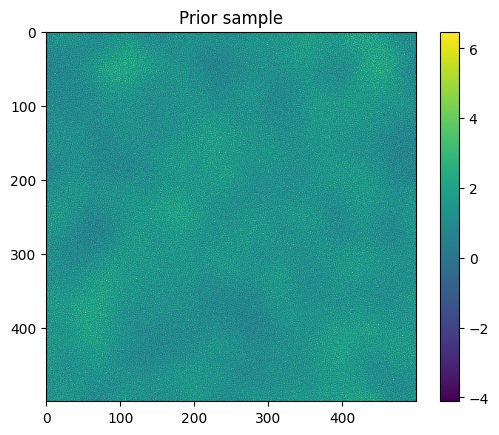

In [8]:
# Draw sample from prior model and plot:

key, sub = random.split(key)
xi = jft.random_like(sub, gp.domain) # generate std normal parameters 
res = gp(xi) # draw sample from gp

plt.imshow(res)
plt.colorbar()
plt.title('Prior sample')
plt.show()

In [9]:
# Define simple signal model without point-sources for now:
class Signal(jft.Model):
    def __init__(self, gp):
        self.gp = gp
        super().__init__(init=self.gp.init)

    def __call__(self, x):
        return self.gp(x)

signal_response = Signal(gp)

# Define noise covariance
# noise_cov_inv = lambda x: 1e-1**-2 * x
noise_cov_inv = lambda x: 5e+0**-2 * x

print("mean:", mapdata_noised.mean())

# Combine in likelihood
lh = jft.Gaussian(mapdata_noised, noise_cov_inv).amend(signal_response)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


mean: 1.3099803369797114


## Next, create a Maximum Aposteriori (MAP) estimation, i.e. best fit point

In [10]:
n_it = 1
# delta = 1e-4
delta = 1e-6
n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=100),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=100
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:0.125 ↺:False #∇²:07 |↘|:2.216004e+04 ➽:2.920950e-01
M: Iteration 1 ⛰:+1.882151e+05 Δ⛰:1.703544e+04
M: →:1.0 ↺:False #∇²:13 |↘|:2.113035e+05 ➽:2.920950e-01
M: Iteration 2 ⛰:+5.473245e+04 Δ⛰:1.334827e+05
M: →:1.0 ↺:False #∇²:19 |↘|:1.553165e+04 ➽:2.920950e-01
M: Iteration 3 ⛰:+3.942448e+04 Δ⛰:1.530797e+04
M: →:0.125 ↺:False #∇²:25 |↘|:2.115862e+03 ➽:2.920950e-01
M: Iteration 4 ⛰:+3.001442e+04 Δ⛰:9.410063e+03
M: →:0.125 ↺:False #∇²:31 |↘|:1.057023e+03 ➽:2.920950e-01
M: Iteration 5 ⛰:+2.252500e+04 Δ⛰:7.489421e+03
M: →:0.25 ↺:False #∇²:37 |↘|:2.503683e+02 ➽:2.920950e-01
M: Iteration 6 ⛰:+1.970008e+04 Δ⛰:2.824916e+03
M: →:0.5 ↺:False #∇²:43 |↘|:2.421858e+02 ➽:2.920950e-01
M: Iteration 7 ⛰:+1.658372e+04 Δ⛰:3.116361e+03
M: →:1.0 ↺:False #∇²:49 |↘|:3.683272e+02 ➽:2.920950e-01
M: Iteration 8 ⛰:+1.480941e+04 Δ⛰:1.774314e+03
M: →:1.0 ↺:False #∇²:55 |↘|:3.025650e+02 ➽:2.920950e-01
M: Iteration 9 ⛰:+1.446330e+04 Δ⛰:3.461085e+02
M: →:1.0 ↺:False #∇²:61 |↘|:4.691062e+0

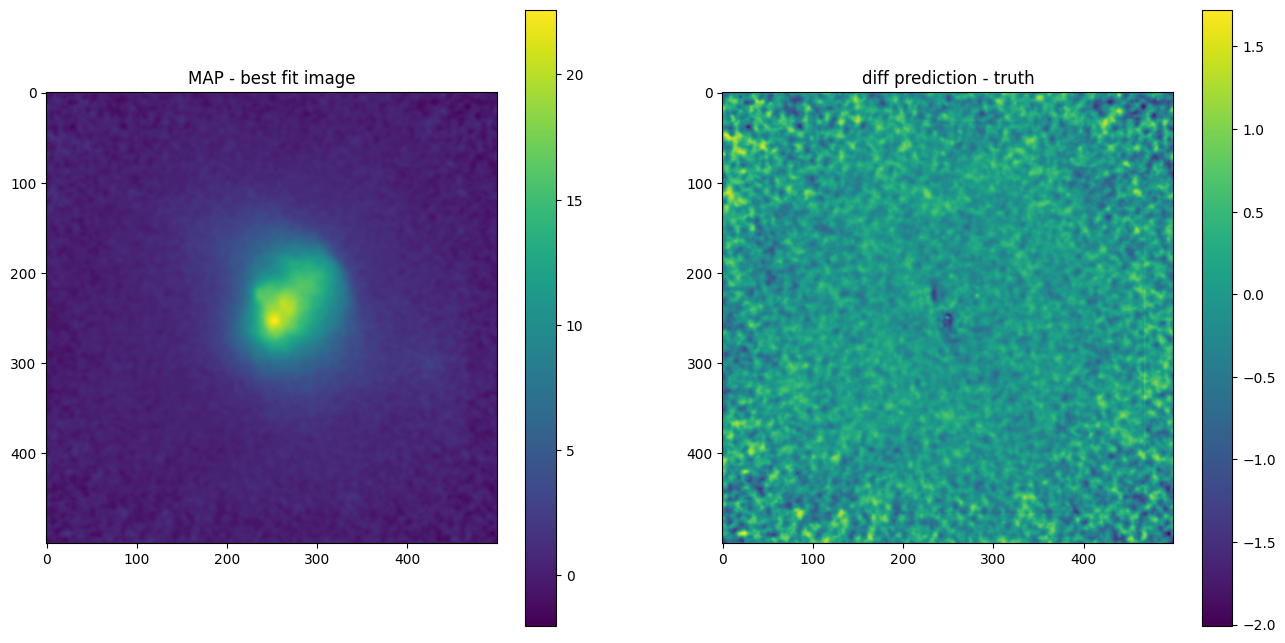

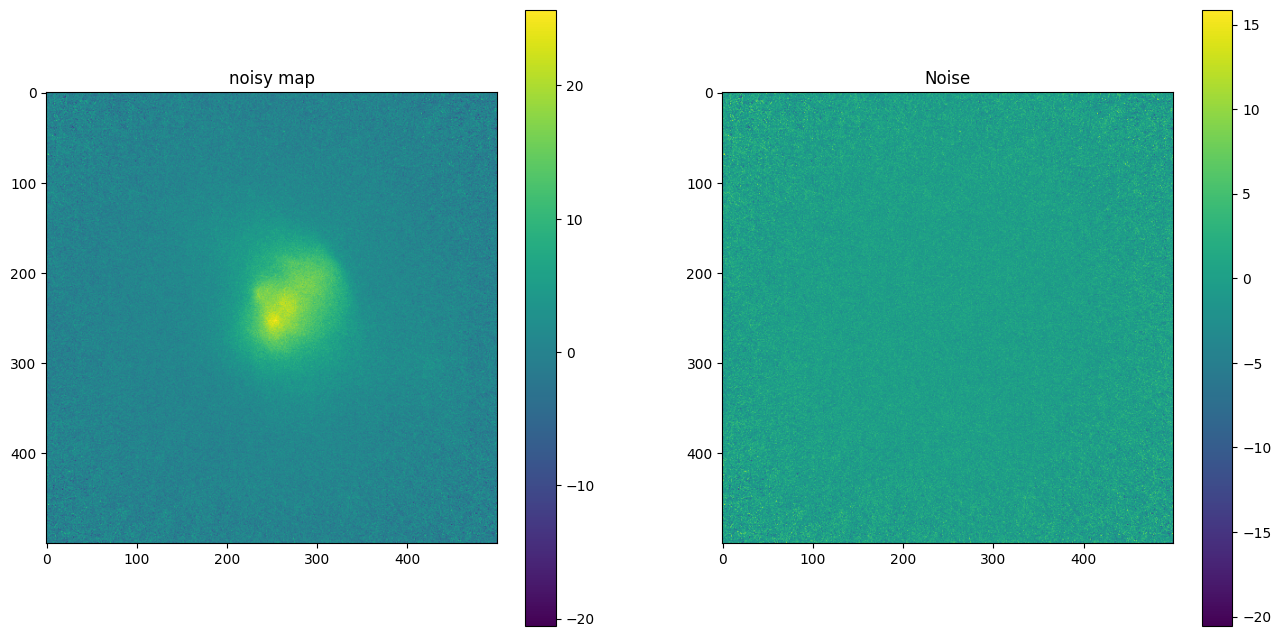

In [11]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos)
sig_map = gp(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow(sig_map - mapdata_truth)
axes[1].title.set_text('diff prediction - truth')
# im1 = axes[1].imshow(mapdata_truth)
# axes[1].title.set_text('truth')
fig.colorbar(im1)

plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(mapdata_noised)
axes[0].title.set_text('noisy map')
fig.colorbar(im0)

im1 = axes[1].imshow(mapdata_noised - mapdata_truth)
axes[1].title.set_text('Noise')
# im1 = axes[1].imshow(mapdata_truth)
# axes[1].title.set_text('truth')
fig.colorbar(im1)

plt.show()

In [13]:
# assert False

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:-1.3406e+05 Δ⛰:inf ➽:2.9209e-02
SL: Iteration 1 ⛰:-1.4234e+05 Δ⛰:8.2827e+03 ➽:2.9209e-02
SL: Iteration 2 ⛰:-1.4288e+05 Δ⛰:5.3570e+02 ➽:2.9209e-02
SL: Iteration 3 ⛰:-1.4457e+05 Δ⛰:1.6897e+03 ➽:2.9209e-02
SL: Iteration 4 ⛰:-1.4504e+05 Δ⛰:4.7338e+02 ➽:2.9209e-02
SL: Iteration 5 ⛰:-1.4534e+05 Δ⛰:2.9816e+02 ➽:2.9209e-02
SL: Iteration 6 ⛰:-1.4548e+05 Δ⛰:1.4384e+02 ➽:2.9209e-02
SL: Iteration 7 ⛰:-1.4559e+05 Δ⛰:1.0678e+02 ➽:2.9209e-02
SL: Iteration 8 ⛰:-1.4564e+05 Δ⛰:5.5145e+01 ➽:2.9209e-02
SL: Iteration 9 ⛰:-1.4569e+05 Δ⛰:4.1284e+01 ➽:2.9209e-02
SL: Iteration 10 ⛰:-1.4574e+05 Δ⛰:5.2338e+01 ➽:2.9209e-02
SL: Iteration 11 ⛰:-1.4575e+05 Δ⛰:1.3271e+01 ➽:2.9209e-02
SL: Iteration 12 ⛰:-1.4577e+05 Δ⛰:2.1924e+01 ➽:2.9209e-02
SL: Iteration 13 ⛰:-1.4580e+05 Δ⛰:2.5866e+01 ➽:2.9209e-02
SL: Iteration 14 ⛰:-1.4580e+05 Δ⛰:5.7589e+00 ➽:2.9209e-02
SL: Iteration 15 ⛰:-1.4582e+05 Δ⛰:1.2476e+01 ➽:2.9209e-02
SL: Iteration 16 ⛰:-1.4583e+05 Δ⛰:1.7687e+01 ➽:2.9209e-02
SL: 

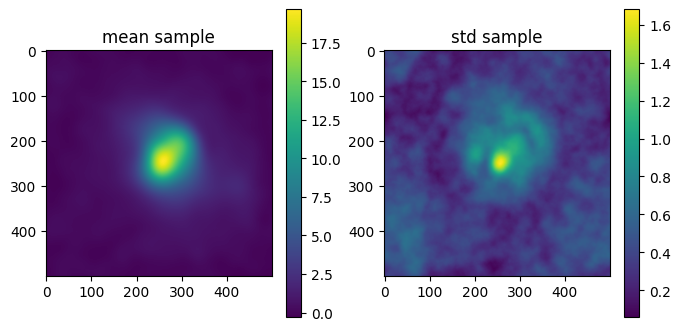

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:-1.3496e+05 Δ⛰:inf ➽:2.9209e-02
SL: Iteration 1 ⛰:-1.4369e+05 Δ⛰:8.7239e+03 ➽:2.9209e-02
SL: Iteration 2 ⛰:-1.4466e+05 Δ⛰:9.7362e+02 ➽:2.9209e-02
SL: Iteration 3 ⛰:-1.4533e+05 Δ⛰:6.6575e+02 ➽:2.9209e-02
SL: Iteration 4 ⛰:-1.4568e+05 Δ⛰:3.5415e+02 ➽:2.9209e-02
SL: Iteration 5 ⛰:-1.4583e+05 Δ⛰:1.5018e+02 ➽:2.9209e-02
SL: Iteration 6 ⛰:-1.4596e+05 Δ⛰:1.2845e+02 ➽:2.9209e-02
SL: Iteration 7 ⛰:-1.4609e+05 Δ⛰:1.3126e+02 ➽:2.9209e-02
SL: Iteration 8 ⛰:-1.4613e+05 Δ⛰:3.8770e+01 ➽:2.9209e-02
SL: Iteration 9 ⛰:-1.4617e+05 Δ⛰:4.2420e+01 ➽:2.9209e-02
SL: Iteration 10 ⛰:-1.4617e+05 Δ⛰:6.6668e-01 ➽:2.9209e-02
SL: Iteration 11 ⛰:-1.4620e+05 Δ⛰:3.3118e+01 ➽:2.9209e-02
SL: Iteration 12 ⛰:-1.4623e+05 Δ⛰:2.5316e+01 ➽:2.9209e-02
SL: Iteration 13 ⛰:-1.4625e+05 Δ⛰:1.4993e+01 ➽:2.9209e-02
SL: Iteration 14 ⛰:-1.4626e+05 Δ⛰:1.0398e+01 ➽:2.9209e-02
SL: Iteration 15 ⛰:-1.4626e+05 Δ⛰:5.1943e+00 ➽:2.9209e-02
SL: Iteration 16 ⛰:-1.4626e+05 Δ⛰:3.2665e+00 ➽:2.9209e-02
SL: 

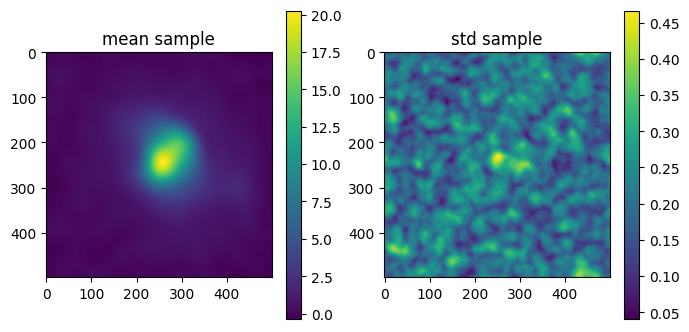

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:-1.2371e+05 Δ⛰:inf ➽:2.9209e-02
SL: Iteration 1 ⛰:-1.3842e+05 Δ⛰:1.4706e+04 ➽:2.9209e-02
SL: Iteration 2 ⛰:-1.4223e+05 Δ⛰:3.8073e+03 ➽:2.9209e-02
SL: Iteration 3 ⛰:-1.4357e+05 Δ⛰:1.3415e+03 ➽:2.9209e-02
SL: Iteration 4 ⛰:-1.4434e+05 Δ⛰:7.6678e+02 ➽:2.9209e-02
SL: Iteration 5 ⛰:-1.4465e+05 Δ⛰:3.1440e+02 ➽:2.9209e-02
SL: Iteration 6 ⛰:-1.4474e+05 Δ⛰:9.1572e+01 ➽:2.9209e-02
SL: Iteration 7 ⛰:-1.4497e+05 Δ⛰:2.2702e+02 ➽:2.9209e-02
SL: Iteration 8 ⛰:-1.4508e+05 Δ⛰:1.0823e+02 ➽:2.9209e-02
SL: Iteration 9 ⛰:-1.4513e+05 Δ⛰:4.9774e+01 ➽:2.9209e-02
SL: Iteration 10 ⛰:-1.4514e+05 Δ⛰:1.8308e+01 ➽:2.9209e-02
SL: Iteration 11 ⛰:-1.4517e+05 Δ⛰:2.1255e+01 ➽:2.9209e-02
SL: Iteration 12 ⛰:-1.4520e+05 Δ⛰:3.4767e+01 ➽:2.9209e-02
SL: Iteration 13 ⛰:-1.4522e+05 Δ⛰:2.2418e+01 ➽:2.9209e-02
SL: Iteration 14 ⛰:-1.4525e+05 Δ⛰:2.2702e+01 ➽:2.9209e-02
SL: Iteration 15 ⛰:-1.4526e+05 Δ⛰:9.3083e+00 ➽:2.9209e-02
SL: Iteration 16 ⛰:-1.4526e+05 Δ⛰:6.0397e+00 ➽:2.9209e-02
SL: 

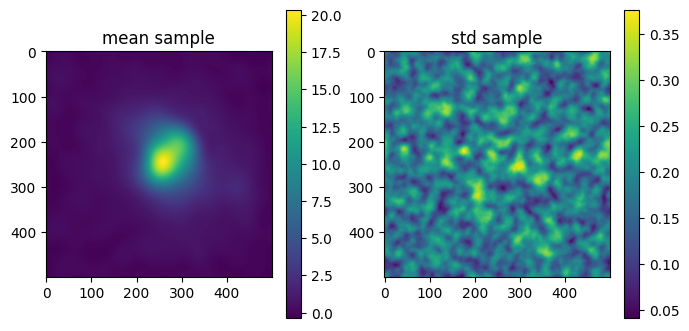

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:-1.0462e+05 Δ⛰:inf ➽:2.9209e-02
SL: Iteration 1 ⛰:-1.3260e+05 Δ⛰:2.7984e+04 ➽:2.9209e-02
SL: Iteration 2 ⛰:-1.4061e+05 Δ⛰:8.0050e+03 ➽:2.9209e-02
SL: Iteration 3 ⛰:-1.4331e+05 Δ⛰:2.7040e+03 ➽:2.9209e-02
SL: Iteration 4 ⛰:-1.4421e+05 Δ⛰:8.9719e+02 ➽:2.9209e-02
SL: Iteration 5 ⛰:-1.4453e+05 Δ⛰:3.1742e+02 ➽:2.9209e-02
SL: Iteration 6 ⛰:-1.4465e+05 Δ⛰:1.2936e+02 ➽:2.9209e-02
SL: Iteration 7 ⛰:-1.4481e+05 Δ⛰:1.5282e+02 ➽:2.9209e-02
SL: Iteration 8 ⛰:-1.4493e+05 Δ⛰:1.2005e+02 ➽:2.9209e-02
SL: Iteration 9 ⛰:-1.4501e+05 Δ⛰:7.9078e+01 ➽:2.9209e-02
SL: Iteration 10 ⛰:-1.4503e+05 Δ⛰:2.0037e+01 ➽:2.9209e-02
SL: Iteration 11 ⛰:-1.4506e+05 Δ⛰:2.8704e+01 ➽:2.9209e-02
SL: Iteration 12 ⛰:-1.4508e+05 Δ⛰:2.9863e+01 ➽:2.9209e-02
SL: Iteration 13 ⛰:-1.4511e+05 Δ⛰:2.8601e+01 ➽:2.9209e-02
SL: Iteration 14 ⛰:-1.4513e+05 Δ⛰:1.7060e+01 ➽:2.9209e-02
SL: Iteration 15 ⛰:-1.4516e+05 Δ⛰:2.6641e+01 ➽:2.9209e-02
SL: Iteration 16 ⛰:-1.4517e+05 Δ⛰:9.1703e+00 ➽:2.9209e-02
SL: 

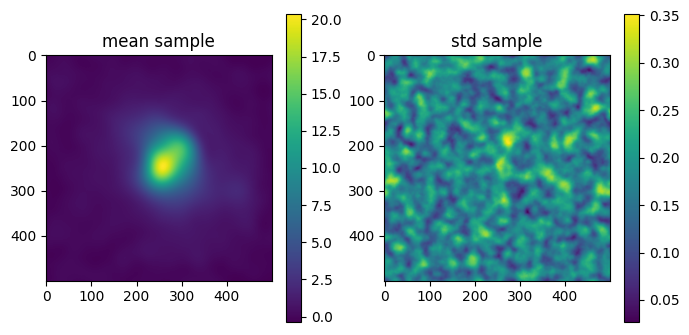

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:-1.3284e+05 Δ⛰:inf ➽:2.9209e-02
SL: Iteration 1 ⛰:-1.3494e+05 Δ⛰:2.1003e+03 ➽:2.9209e-02
SL: Iteration 2 ⛰:-1.4080e+05 Δ⛰:5.8583e+03 ➽:2.9209e-02
SL: Iteration 3 ⛰:-1.4311e+05 Δ⛰:2.3096e+03 ➽:2.9209e-02
SL: Iteration 4 ⛰:-1.4422e+05 Δ⛰:1.1107e+03 ➽:2.9209e-02
SL: Iteration 5 ⛰:-1.4469e+05 Δ⛰:4.7166e+02 ➽:2.9209e-02
SL: Iteration 6 ⛰:-1.4492e+05 Δ⛰:2.3009e+02 ➽:2.9209e-02
SL: Iteration 7 ⛰:-1.4505e+05 Δ⛰:1.2763e+02 ➽:2.9209e-02
SL: Iteration 8 ⛰:-1.4520e+05 Δ⛰:1.5327e+02 ➽:2.9209e-02
SL: Iteration 9 ⛰:-1.4528e+05 Δ⛰:8.1808e+01 ➽:2.9209e-02
SL: Iteration 10 ⛰:-1.4535e+05 Δ⛰:6.4717e+01 ➽:2.9209e-02
SL: Iteration 11 ⛰:-1.4535e+05 Δ⛰:2.0399e+00 ➽:2.9209e-02
SL: Iteration 12 ⛰:-1.4539e+05 Δ⛰:3.7091e+01 ➽:2.9209e-02
SL: Iteration 13 ⛰:-1.4542e+05 Δ⛰:2.9723e+01 ➽:2.9209e-02
SL: Iteration 14 ⛰:-1.4544e+05 Δ⛰:1.9591e+01 ➽:2.9209e-02
SL: Iteration 15 ⛰:-1.4546e+05 Δ⛰:2.6997e+01 ➽:2.9209e-02
SL: Iteration 16 ⛰:-1.4547e+05 Δ⛰:1.1366e+01 ➽:2.9209e-02
SL: 

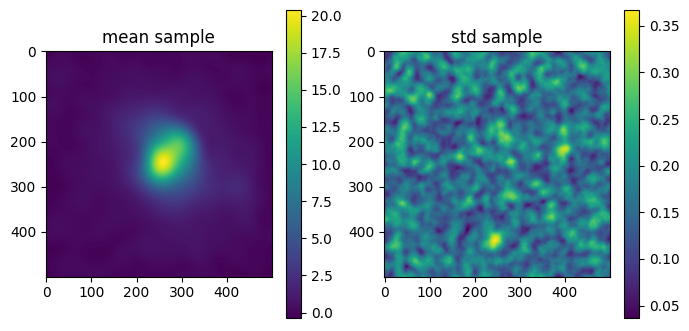

OPTIMIZE_KL: Starting 0006
SL: Iteration 0 ⛰:-1.2218e+05 Δ⛰:inf ➽:2.9209e-02
SL: Iteration 1 ⛰:-1.3097e+05 Δ⛰:8.7930e+03 ➽:2.9209e-02
SL: Iteration 2 ⛰:-1.3965e+05 Δ⛰:8.6752e+03 ➽:2.9209e-02
SL: Iteration 3 ⛰:-1.4419e+05 Δ⛰:4.5443e+03 ➽:2.9209e-02
SL: Iteration 4 ⛰:-1.4514e+05 Δ⛰:9.4679e+02 ➽:2.9209e-02
SL: Iteration 5 ⛰:-1.4547e+05 Δ⛰:3.2623e+02 ➽:2.9209e-02
SL: Iteration 6 ⛰:-1.4569e+05 Δ⛰:2.2300e+02 ➽:2.9209e-02
SL: Iteration 7 ⛰:-1.4582e+05 Δ⛰:1.3300e+02 ➽:2.9209e-02
SL: Iteration 8 ⛰:-1.4590e+05 Δ⛰:8.0033e+01 ➽:2.9209e-02
SL: Iteration 9 ⛰:-1.4598e+05 Δ⛰:7.4494e+01 ➽:2.9209e-02
SL: Iteration 10 ⛰:-1.4605e+05 Δ⛰:7.1852e+01 ➽:2.9209e-02
SL: Iteration 11 ⛰:-1.4605e+05 Δ⛰:1.8321e+00 ➽:2.9209e-02
SL: Iteration 12 ⛰:-1.4609e+05 Δ⛰:3.4860e+01 ➽:2.9209e-02
SL: Iteration 13 ⛰:-1.4613e+05 Δ⛰:3.9430e+01 ➽:2.9209e-02
SL: Iteration 14 ⛰:-1.4614e+05 Δ⛰:1.6343e+01 ➽:2.9209e-02
SL: Iteration 15 ⛰:-1.4617e+05 Δ⛰:2.7130e+01 ➽:2.9209e-02
SL: Iteration 16 ⛰:-1.4618e+05 Δ⛰:9.4802e+00 ➽:2.9209e-02
SL: 

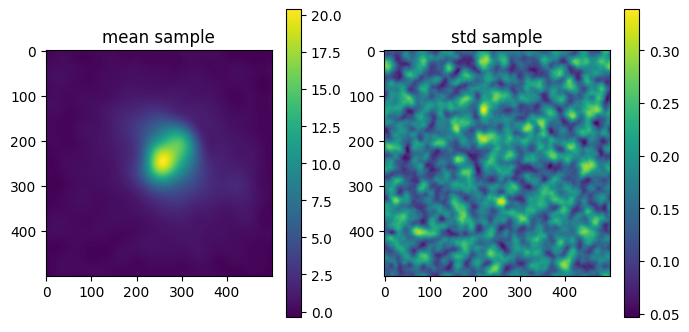

In [14]:
n_it = 6
# delta = 1e-4
delta = 1e-6
n_samples = 8 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(gp(s) for s in samples))
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    im0 = axes[0].imshow(mean)
    axes[0].title.set_text('mean sample')
    fig.colorbar(im0)

    im1 = axes[1].imshow(std)
    axes[1].title.set_text('std sample')
    fig.colorbar(im1)
    
    plt.show()

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=100),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=100
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    callback=callback,
)

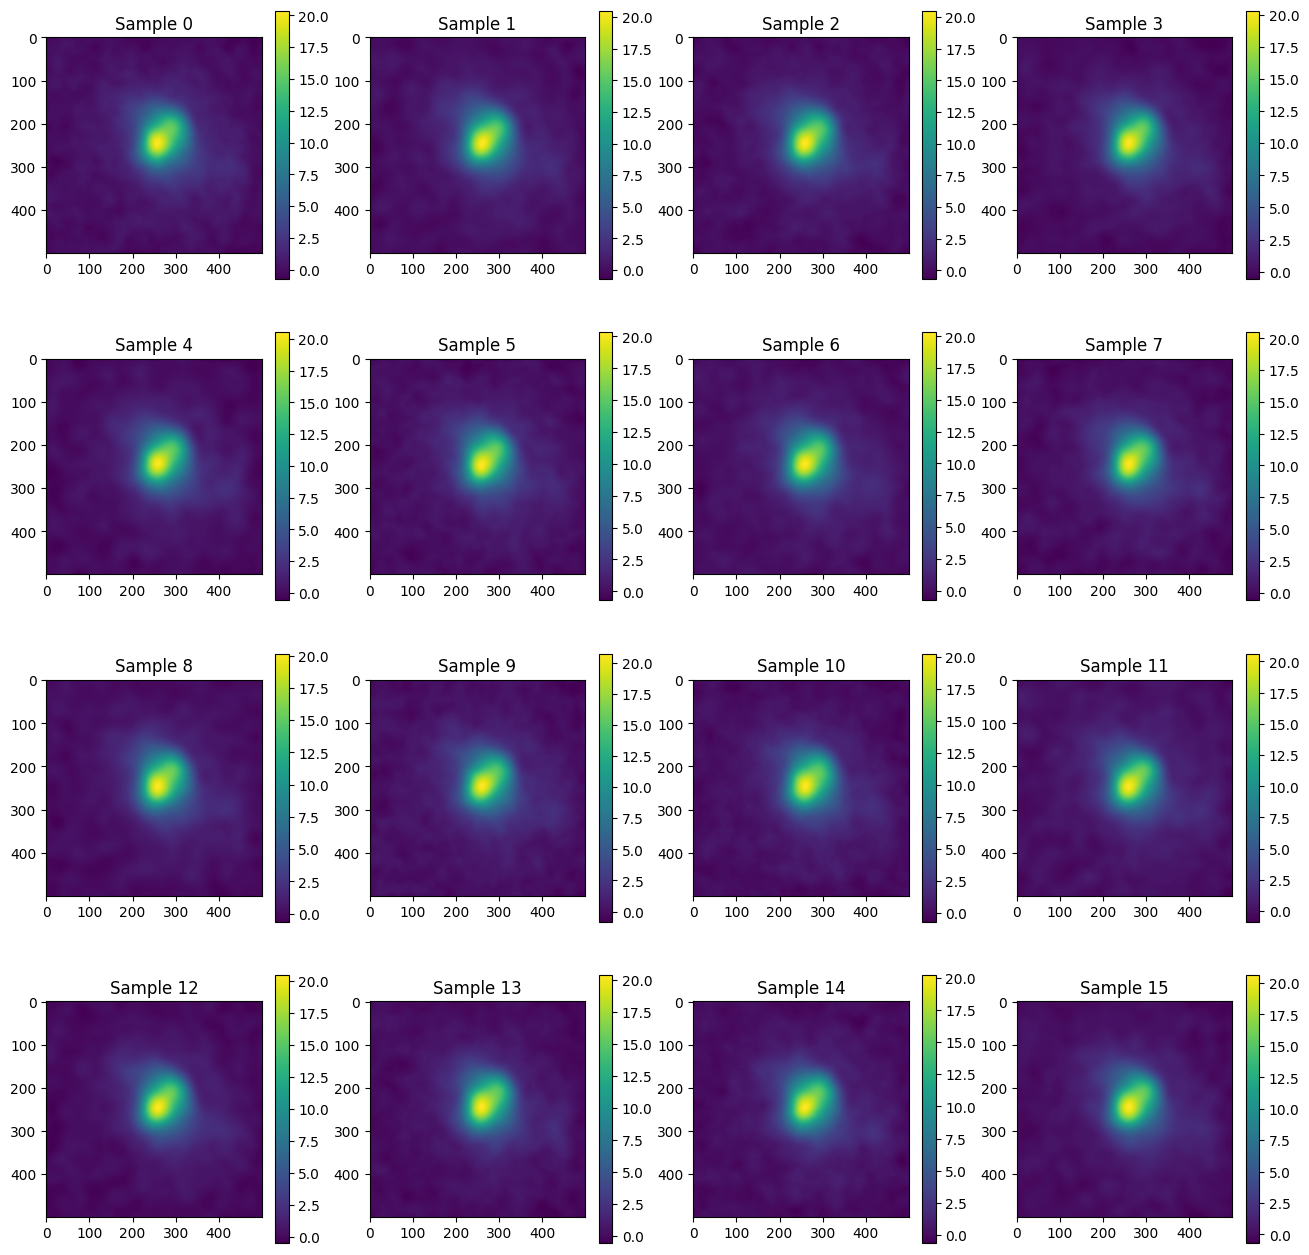

In [15]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

i = 0
for s in samples:
    # print(i//4, i%4)
    im = axes[i//4][i%4].imshow(gp(s))
    axes[i//4][i%4].title.set_text(f"Sample {i}")
    fig.colorbar(im)
    
    i += 1

plt.show()

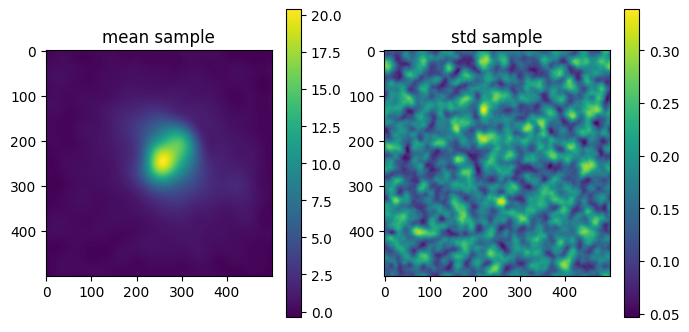

In [16]:
mean, std = jft.mean_and_std(tuple(gp(s) for s in samples))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

im0 = axes[0].imshow(mean)
axes[0].title.set_text('mean sample')
fig.colorbar(im0)

im1 = axes[1].imshow(std)
axes[1].title.set_text('std sample')
fig.colorbar(im1)

plt.show()